# Проект для «Викишоп»

***Описание проекта:***

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. В нашем распоряжении набор данных с разметкой о токсичности правок.

***Цели проекта:***
- Обучить модель классифицировать комментарии на позитивные и негативные.
- Построить модель со значением метрики качества *F1* не меньше 0.75. 

***Инструкция по выполнению проекта:***

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

***Описание данных:***

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Сначала установим необходимые библиотеки:

In [1]:
!pip install -q scikit-learn --upgrade
!pip install -q imbalanced-learn --upgrade

Далее импортируем библиотеки, необходимые для работы:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import re 
  
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

Считываем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм df_tc. Путь к файлу - /datasets/toxic_comments.csv. 

In [3]:
df_tc = pd.read_csv('/datasets/toxic_comments.csv')

Проверим, что данные в таблице соответствуют описанию. Выведем одну случайную строку датафрейма:

In [4]:
df_tc.sample(1)

,Unnamed: 0,text,toxic
149268,149424,"""\n\n{{unblock|I am NOT vandalizing! I was me...",0


Таким образом, представленные исходные данные соответствуют описанию.

Проведём предобработку данных.

Для начала создадим  2 функции: 
- data_main_info, которая будет выводить общую информацию о каждом датафрейме с помощью методов: info() и head();
- data_preprocessing, которая будет определять количество пропущенных значений в каждом столбце и искать явные дубликаты:

In [5]:
def data_main_info(data):
       
    print(f'Общая информация:') 
    print(data.info())
    print()
    print(f'Первые пять строк таблицы:')
    display(data.head())

In [6]:
def data_preprocessing(data):
    print(f'Количество пропущенных значений в каждом столбце:')
    print(data.isna().sum())
    print()   
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')

Рассмотрим общую информацию о датафрейме:

In [7]:
data_main_info(df_tc)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None

Первые пять строк таблицы:


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


В выборке имеется 159292 строк и 3 столбца, а все типы данных соответствуют содержимому.

Проверим данные на наличие пропусков и дубликатов:

In [8]:
data_preprocessing(df_tc)

Количество пропущенных значений в каждом столбце:
Unnamed: 0    0
text          0
toxic         0
dtype: int64

Количество явных дубликатов: 0


Пропуски и явные дубликаты в датафрейме отсутствуют.

Удалим неинформативный признак 'Unnamed: 0':

In [9]:
df_tc = df_tc.drop(['Unnamed: 0'], axis=1)

Продолжим подготовку датафрейма к машинному обучению. Создадим функцию lemmatize_clear, которая приведёт все символы к нижнему регистру, очистит текст от лишних символов с помощью регулярных выражений и лемматизирует текст: 

In [10]:
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemmatize_clear(text):
    text = text.lower()
    lemm_text = " ".join(lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text)

    return " ".join(cleared_text.split())

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Применим функцию к столбцу 'text' нашего датафрейма, создав в новый столбец 'lemm_text' :

In [11]:
df_tc['lemm_text'] = df_tc['text'].progress_apply(lemmatize_clear)

  0%|          | 0/159292 [00:00<?, ?it/s]

Удалим столбец 'text' из датафрейма:

In [12]:
df_tc = df_tc.drop(['text'], axis=1)

In [13]:
df_tc.head()

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i ca n t make any real suggestion on impr...
4,0,you sir be my hero any chance you remember wha...


Далее разделим датафрейм на тренировочную и тестовую выборки и проверим соотношение классов целевого признака toxic:

In [14]:
RANDOM_STATE = 42

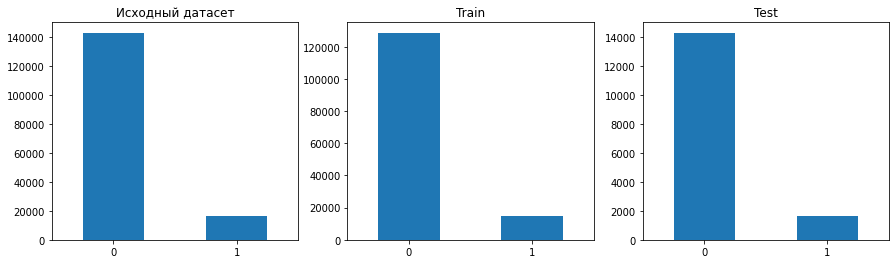

In [15]:
# сохраним входные и целевые признаки
X = df_tc['lemm_text']
y = df_tc['toxic']

# сформируем тренировочную и тестовую выборки
# зафиксируем random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    random_state=RANDOM_STATE,
    test_size=0.1,
    stratify=y
)

# визуализация баланса целевого признака в выборках
fig, ax = plt.subplots(1,3, figsize=(15,4))
y.value_counts().plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title("Исходный датасет")
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title("Train")
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0)
ax[2].set_title("Test")
plt.show()

Классы несбалансированы, попробуем оставить их в таком виде.

*Таким образом, была проведена подготовка данных:*
- неинформативный столбец 'Unnamed: 0' был удалён;
- данные в столбце text были приведены к нижнему регистру, лишние символы очищены регулярными выражениями, символы лемматизированы;
- классы в целевом признаке toxic оставили несбалансированными.

## Обучение

Данные подготовлены. Перейдём к обучению моделей. Будем использовать следующие модели:
- LogisticRegression;
- DecisionTreeClassifier;
- CatBoostClassifier;
- LightGBMClassifier.

Качество моделей будем определять метрикой F1: её значение должно быть не менее 0.75.

Сначала найдём стоп-слова в английском языке:

In [16]:
nltk.download('stopwords')

stopwords = list(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Сделаем пайплайны для создания TF-IDF с помощью TfidfVectorizer обучения моделей на тренировочной выборке. Рассчитаем  метрику F1 на кросс-валидации для поиска лучшей модели: 

In [17]:
pipe_logreg= Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords)),
    ('model', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
])

parameters_logreg = {
    'model__C': range(1, 10)
}
            
# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 3, метрика f1 и n_jobs=-1.
gs_lr = GridSearchCV(
    pipe_logreg,
    parameters_logreg,
    n_jobs=-1,
    cv=3,
    scoring='f1',
    error_score='raise'
)

gs_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_lr.best_estimator_)
print()
print('Метрика F1 лучшей модели на кросс-валидации:', gs_lr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('model',
                 LogisticRegression(C=7, class_weight='balanced',
                                    random_state=42))])

Метрика F1 лучшей модели на кросс-валидации: 0.7550040403834694


In [18]:
pipe_tree= Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords)),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

parameters_tree = {
    'model__max_depth': range(2, 5),
    'model__max_features': range(2, 5)
}
            
# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 3, метрика f1 и n_jobs=-1.
gs_tree = GridSearchCV(
    pipe_tree,
    parameters_tree,
    n_jobs=-1,
    cv=3,
    scoring='f1'
)

gs_tree.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', gs_tree.best_estimator_)
print()
print('Метрика F1 лучшей модели на кросс-валидации:', gs_tree.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                                        max_features=4, random_state=42))])

Метрика F1 лучшей модели на кросс-валидации: 0.12408641311508513


In [19]:
pipe_cbc= Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords)),
    ('model', CatBoostClassifier(random_state=RANDOM_STATE, loss_function="Logloss", verbose=False))
])

parameters_cbc = {
    'model__iterations': [10, 50, 100],
    'model__depth': range(1, 3)
}

# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 3, метрика f1 и n_jobs=-1.
gs_cbc = GridSearchCV(
    pipe_cbc,
    parameters_cbc,
    cv=3,
    scoring='f1'
)

gs_cbc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_cbc.best_estimator_)
print()
print('Метрика F1 лучшей модели на кросс-валидации:', gs_cbc.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7f5c257600a0>)])

Метрика F1 лучшей модели на кросс-валидации: 0.6993719232089974


In [20]:
pipe_lgbm= Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords)),
    ('model', LGBMClassifier(random_state=RANDOM_STATE))
])

parameters_lgbm = {
    'model__learning_rate': [.1, .5],
    'model__num_leaves': [25, 50]
}

# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 3, метрика f1 и n_jobs=-1.
gs_lgbm = GridSearchCV(
    pipe_lgbm,
    parameters_lgbm,
    cv=3,
    scoring='f1'
)

gs_lgbm.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_lgbm.best_estimator_)
print()
print('Метрика F1 лучшей модели на кросс-валидации:', gs_lgbm.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('model',
                 LGBMClassifier(learning_rate=0.5, num_leaves=50,
                                random_state=42))])

Метрика F1 лучшей модели на кросс-валидации: 0.763240318527675


In [21]:
# объединяем результаты в одну таблицу
results = pd.DataFrame([
    [round(gs_lr.best_score_, 3)],
    [round(gs_tree.best_score_, 3)],
    [round(gs_cbc.best_score_, 3)],
    [round(gs_lgbm.best_score_, 3)]
])

results.index = [
    'LogisticRegresson',
    'DecisionTreeClassifier',
    'CatBoostClassifier',
    'LightGBMClassifier'
]

results.columns = ['f1_score']

display(results)

,f1_score
LogisticRegresson,0.755
DecisionTreeClassifier,0.124
CatBoostClassifier,0.699
LightGBMClassifier,0.763


Как можно видеть, требуемому условию качества (значение метрики F1 не менее 0.75) не удовлетворяют модели DecisionTreeClassifier (совсем низкий показатель - 0.124) и CatBoostClassifier (немного меньше 0.75 - 0.699). Модель логистической регрессии и модель LightGBMClassifier (с градиентным бустингом) показали высокие результаты: 0.755 и 0.763, соответственно. 

*Таким образом, модель LightGBMClassifier (learning_rate=0.5, num_leaves=50, random_state=42) наилучшим образом классифицирует комментарии на положительные и отрицательные на кросс-валидации.*

## Выводы

Проведём теперь тестирование лучшей модели:

In [22]:
y_pred_lgbm = gs_lgbm.best_estimator_.predict(X_test)
f1_lgbm_test = f1_score(y_pred_lgbm, y_test)

print('f1_score_light_gbm_classifier_test', round(f1_lgbm_test, 3))

f1_score_light_gbm_classifier_test 0.775


Для наилучшей на кросс-валидации модели LightGBMClassifier метрика F1 на тестовой выборке оказалась равной 0.775.

***Выводы:***

1. Подготовка данных:

В этой задаче было представлена таблица с данными с разметкой о токсичности правок. Таблица содержит 159292 строк и 3 столбца.

- представленные исходные данные соответствуют описанию;
- в данных отсутствуют пропуски и явные дубликаты;
- типы данных соответствует содержимому.

В результате подготовки данных:
- удалён неинформативный столбец 'Unnamed: 0';
- текстовые данные приведены к нижнему регистру, очищены регулярными выражениями и лемматизированы;
- несбалансированность классов целевого признака toxic оставили.


2. Обучение моделей:

Поскольку предсказание позитивных и негативных комментариев представляет собой задачу классификации, применялись следующие четыре модели: логистическая регрессия (LogisticRegression), дерево решений (DecisionTreeClassifier) и 2 модели градиентного бустинга (CatBoostClassifier и LightGBMClassifier).

Для обучения всех моделей использовались пайплайны с векторайзером TfidfVectorizer, а подбор гиперпараметром осуществлялся с помощью GridSearchCV.

Для выбранных моделей рассчитывалась метрика F1, значение которой должно было быть не менее 0.75.

На крос-валидации было показано, что модель LightGBMClassifier даёт наилучшие результаты для несбалансированного текста: 0.763. 

3. Выводы:

Таким образом, было найдено, что наилучшая модель LightGBMClassifier (с параметрами: learning_rate=0.5, num_leaves=50, random_state=42) на тестовой выборке даёт метрику F1 на уровне 0.775 и наилучшим образом классифицирует комментарии на положительные и отрицательные.